In [1]:

import multiprocessing
print(multiprocessing.cpu_count())

import psutil
print(f"Available memory before training: {psutil.virtual_memory().available / 1e9:.2f} GB")

12
Available memory before training: 8.57 GB


In [2]:

import numpy as np
import pandas as pd
pd.set_option('display.max_info_columns', 200) #caps at 200, use None to show all
pd.set_option('display.max_rows', 200)

#from my_utils import evaluate_and_save_pipeline

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time
import joblib
import pickle

In [3]:

token = 'p23'
study = pd.read_pickle("p004_diabetes_MLprep.pkl")

for col in study.select_dtypes(include='int64'):
    study[col] = study[col].astype('int32')

print(study.shape) 

(78743, 176)


In [4]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder 
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score as sklearn_accuracy_score
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier


In [5]:

X = study.drop(['readmitted_ind'], axis=1)
y = study['readmitted_ind']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, stratify=y_train, train_size=25000, random_state=23)

# Define features to EXCLUDE for training
exclude_features = ['patient_nbr', 'encounter_id', 'diagnosis_tuple', 'readmitted', 'dummy'] 
numeric_features = [col for col in X.columns if col not in exclude_features and X[col].dtype == 'int32']
object_features = [col for col in X.columns if col not in exclude_features and X[col].dtype == 'object']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), object_features)
    ])

In [6]:

%%time
# Define hyperparameter grid
param_dist = { 
    'loss': [ 'log_loss'
            , 'squared_hinge'
            , 'hinge'
            , 'modified_huber'
            , 'squared_error'],  
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1],   # Dropped 1e-5
    'penalty': ['l1', 'l2', 'elasticnet'],  
    'max_iter': [5000, 10000, 15000],  # Increased iteration range
    'tol': [1e-3, 1e-4]  # Removed overly strict tolerance
}

# Initialize model
sgd_object = SGDClassifier(n_jobs=-1)

randomSearchCV_SGD = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomizedSearchCV(sgd_object, param_distributions=param_dist, 
                            n_iter=50, cv=5, verbose=1, n_jobs=-1, random_state=23))  # Final model after selection
])

# Fit on a subset (optional for speed)
randomSearchCV_SGD.fit(X_sample, y_sample)

with open(f"{token}_randomSearchCV_SGD.pkl", "wb") as file:
    pickle.dump(randomSearchCV_SGD, file)
print(f"Model saved as {token}_randomSearchCV_SGD.pkl")

# Get best parameters
best_params = randomSearchCV_SGD['model'].best_params_
print("🔥 Best Parameters:", best_params)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Model saved as p23_randomSearchCV_SGD.pkl
🔥 Best Parameters: {'tol': 0.001, 'penalty': 'l1', 'max_iter': 5000, 'loss': 'modified_huber', 'alpha': 0.001}
CPU times: total: 47.1 s
Wall time: 1h 16min 29s


In [7]:

 # Extract cv_results_ safely
cv_results_df = pd.DataFrame(randomSearchCV_SGD['model'].cv_results_)

# Identify failed fits (mean_test_score is NaN)
failed_fits = cv_results_df[cv_results_df['mean_test_score'].isna()]
print("❌ Failed Fits:")
print(failed_fits[['params']])
print(f"Total failed fits: {len(failed_fits)}")

# Create leaderboard from successful fits
successful_fits = cv_results_df[cv_results_df['mean_test_score'].notna()]

leaderboard = successful_fits[
    ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
].sort_values(by='rank_test_score').reset_index(drop=True)

# Export leaderboard
leaderboard.to_csv(f'{token}_randomSearchCV_SGD_leaderboard.csv', index=False)

# Show top 10
print("🏆 Top 10 Hyperparameter Sets:")
print(leaderboard.head(10))


❌ Failed Fits:
Empty DataFrame
Columns: [params]
Index: []
Total failed fits: 0
🏆 Top 10 Hyperparameter Sets:
                                              params  mean_test_score  \
0  {'tol': 0.001, 'penalty': 'l1', 'max_iter': 50...          0.94748   
1  {'tol': 0.001, 'penalty': 'l1', 'max_iter': 50...          0.93428   
2  {'tol': 0.0001, 'penalty': 'l1', 'max_iter': 1...          0.92652   
3  {'tol': 0.0001, 'penalty': 'elasticnet', 'max_...          0.92484   
4  {'tol': 0.0001, 'penalty': 'l1', 'max_iter': 1...          0.91928   
5  {'tol': 0.001, 'penalty': 'l2', 'max_iter': 50...          0.91892   
6  {'tol': 0.001, 'penalty': 'l2', 'max_iter': 15...          0.91872   
7  {'tol': 0.0001, 'penalty': 'l2', 'max_iter': 1...          0.91768   
8  {'tol': 0.001, 'penalty': 'l2', 'max_iter': 50...          0.89892   
9  {'tol': 0.001, 'penalty': 'l2', 'max_iter': 15...          0.89720   

   std_test_score  rank_test_score  
0        0.002773                1  
1        0.0

In [8]:

%%time
# Fit final model with best hyperparameters on **full dataset**
SGD = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SGDClassifier(**best_params, random_state=42, n_jobs=-1))  # Final model after selection
])

SGD.fit(X_train, y_train)

with open(f"{token}_SGD.pkl", "wb") as file:
    pickle.dump(SGD, file)
print(f"Model saved as {token}_SGD.pkl")

Model saved as p23_SGD.pkl
CPU times: total: 4.59 s
Wall time: 4.65 s


Fits data saved as fits_pickle_p23_SGD.pkl
Metrics saved to fits_pickle_p23_SGD.pkl
MSE (Train): 0.0494
MSE (Test): 0.0511
R-sq (Train): 0.9506
R-sq (Test): 0.9489
Accuracy: 0.9489
accuracy_score: 0.9489
Sensitivity: 0.9553
Specificity: 0.9435


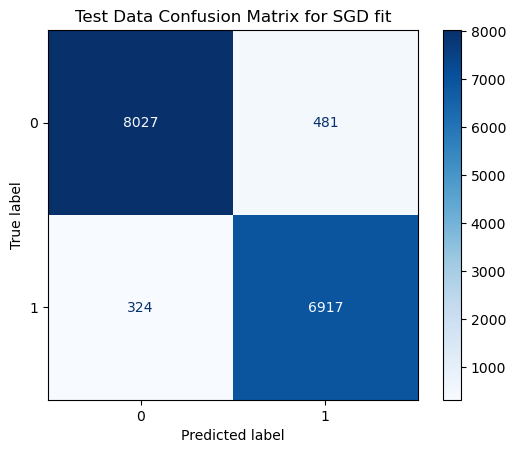

{'model_version': 'p23_SGD',
 'mse_train': 0.04943327935993904,
 'mse_test': 0.05111435646707727,
 'r2_train': 0.950566720640061,
 'r2_test': 0.9488856435329227,
 'y_test': array([1, 0, 1, ..., 0, 0, 1]),
 'y_train_pred': array([1, 0, 1, ..., 0, 1, 0]),
 'y_test_pred': array([1, 0, 1, ..., 0, 0, 1]),
 'display_labels': array([0, 1]),
 'tn': 8027,
 'fp': 481,
 'fn': 324,
 'tp': 6917,
 'sensitivity': 0.9552547990609032,
 'specificity': 0.943464974141984,
 'fpr': array([0.        , 0.01868829, 0.01868829, ..., 0.32275505, 0.32299013,
        1.        ]),
 'tpr': array([0.        , 0.76025411, 0.76204944, ..., 0.97362243, 0.97362243,
        1.        ]),
 'thresholds': array([           inf, 1.00000000e+00, 9.89847197e-01, ...,
        9.62182315e-05, 1.96483680e-05, 0.00000000e+00]),
 'auc': 0.9679363328774718}

In [9]:

def evaluate_and_save_pipeline(pipeline, namestring, token, 
                               X_train, X_test, 
                               y_train, y_test):
    """
    Evaluates a trained pipeline and saves metrics to a pickle file.
    """

    # Properly check for missing inputs
    if any(v is None for v in [X_train, X_test, y_train, y_test]):
        raise ValueError("X_train, X_test, y_train, or y_test must not be None.")

    # Ensure data is in expected format (convert to numpy if necessary)
    y_train = y_train.values if hasattr(y_train, "values") else y_train
    y_test = y_test.values if hasattr(y_test, "values") else y_test

    # Make predictions
    y_test_pred = pipeline.predict(X_test)
    y_train_pred =  pipeline.predict(X_train)
    
    # Determine if model supports predict_proba or decision_function
    if hasattr(pipeline, "predict_proba"):
        y_test_pred_pct = pipeline.predict_proba(X_test)[:, 1]
    elif hasattr(pipeline, "decision_function"):
        y_test_pred_pct = pipeline.decision_function(X_test)
    else:
        raise AttributeError("🚨 This pipeline has neither predict_proba() nor decision_function(). Cannot generate continuous scores for ROC/AUC.")

    # Calculate metrics
    mse_train = mean_squared_error(y_train, pipeline.predict(X_train))
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_train = pipeline.score(X_train, y_train)
    r2_test = pipeline.score(X_test, y_test)

    # Confusion matrix & sensitivity/specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    accuracy = (tn+tp)/ (tn+tp+fn+fp)
    accuracy_score = sklearn_accuracy_score(y_test, y_test_pred) 
    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_pct)
    roc_auc = auc(fpr, tpr)

    # Save metrics
    pickle_metrics = {
        'model_version': f"{token}_{namestring}",
        'mse_train': mse_train,
        'mse_test': mse_test,
        'r2_train': r2_train,
        'r2_test': r2_test,
        'y_test': y_test,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'display_labels': pipeline.classes_ ,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'auc': roc_auc
    }
    
    filename = f"fits_pickle_{token}_{namestring}.pkl"
    with open(filename, "wb") as file:
        pickle.dump(pickle_metrics, file)
    print(f"Fits data saved as {filename}")

    # Print summary
    print(f"Metrics saved to {filename}")
    print('MSE (Train):',  round(mse_train,4))
    print('MSE (Test):',   round(mse_test, 4))
    print('R-sq (Train):', round(r2_train, 4))
    print('R-sq (Test):',  round(r2_test,  4))
    print('Accuracy:', round(accuracy, 4))
    print('accuracy_score:', round(accuracy_score,4))
    print('Sensitivity:', round(sensitivity,4))
    print('Specificity:', round(specificity,4))
    

    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"Test Data Confusion Matrix for {namestring} fit")
    plt.show()

    return pickle_metrics
    
evaluate_and_save_pipeline(pipeline=SGD
                               , namestring='SGD'
                               , token=token
                               , X_train=X_train
                               , X_test=X_test
                               , y_train=y_train
                               , y_test=y_test)

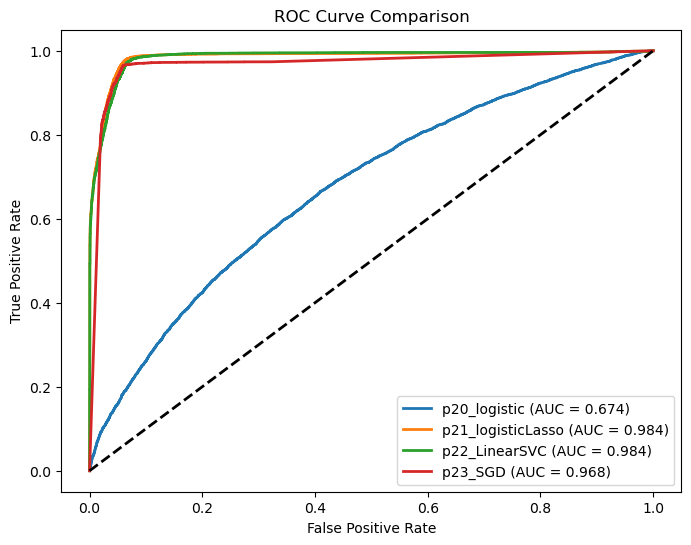

In [10]:

fits_pickles =['fits_pickle_p20_logistic.pkl'
             , 'fits_pickle_p21_logisticLasso.pkl'
             , 'fits_pickle_p22_LinearSVC.pkl'
             , 'fits_pickle_p23_SGD.pkl' ]

colors = [
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # purple
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f',  # gray
    '#bcbd22',  # lime
    '#17becf',  # cyan
    '#393b79',  # dark blue
    '#637939'   # dark green
]

def plot_roc_curves(fits_pickles):
    plt.figure(figsize=(8, 6))
    
    for i, file in enumerate(fits_pickles):
        model_data = pd.read_pickle(file)
        plt.plot(model_data['fpr'], model_data['tpr'], color=colors[i % len(colors)], lw=2, 
                 label=f"{model_data['model_version']} (AUC = {model_data['auc']:.3f})")
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Random baseline
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")
    plt.show()

# Example usage:
# plot_roc_curves(['lasso_metrics.pkl', 'ridge_metrics.pkl'])
plot_roc_curves(fits_pickles)

In [11]:

#All this is necessary to get transformed features names out of the L1-penalty logistic model fit, apparently.
X_train.drop(columns=exclude_features, inplace=True)

# Fit the preprocessor separately on the training data
preprocessor.fit(X_train)

# Function to extract transformed feature names
def get_feature_names_from_preprocessor(preprocessor, numeric_features):
    """Retrieve feature names after transformation, including OneHotEncoding."""
    feature_names = []
    
    for name, transformer, features in preprocessor.transformers_:
        if isinstance(transformer, OneHotEncoder):
            # Get feature names for one-hot encoded categorical variables
            encoded_features = transformer.get_feature_names_out(features)
            feature_names.extend(encoded_features)
        else:
            # Numeric features are passed through unchanged
            feature_names.extend(features)

    return feature_names

# Extract feature names AFTER fitting the preprocessor
transformed_feature_names = get_feature_names_from_preprocessor(preprocessor, numeric_features)


# Extract coefficients from the trained logistic LASSO model
coefficients = SGD.named_steps['model'].coef_.flatten()

# Verify if the lengths now match
num_features = len(transformed_feature_names)
num_coefficients = len(coefficients)

if num_features == num_coefficients:
    coef_df = pd.DataFrame({'Feature': transformed_feature_names, 'Coefficient': coefficients})
else:
    print(f"Warning: Mismatch in feature names ({num_features}) and coefficients ({num_coefficients}). DataFrame truncated.")
    coef_df = pd.DataFrame({
        'Feature': transformed_feature_names[:min(num_features, num_coefficients)],
        'Coefficient': np.round(coefficients[:min(num_features, num_coefficients)],6) 
    })

coef_df['zero_ind'] = (coef_df['Coefficient']==0).astype(int)
coef_df['abs_coef'] = round(abs(coef_df['Coefficient']),6)
coef_df['gt_1_ind'] = (abs(coef_df['Coefficient'])> 1 ).astype(int)
coef_df['dummy'] = 1

coef_df.to_csv(f'{token}_SGD_coefficients.csv',index=False,  float_format="%.6f")
print(f'coefficients printed out as {token}_SGD_coefficients.csv')


coefficients printed out as p23_SGD_coefficients.csv
